In [7]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.results import Results
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from ephysvibe.spike_sorting import config
from ephysvibe.task import task_constants
from ephysvibe.task.task_constants import EVENTS_B1_SHORT
from ephysvibe.trials.spikes import firing_rate, sp_constants

In [54]:
path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/2022-12-05_10-51-52_Riesling_lip_e1_r1_good1_neu.h5'
neu = NeuronData.from_python_hdf5(path)
nid = neu.get_neuron_id()

In [55]:
def select_trials_by_percentile(
    x:np.ndarray, percentile1: list, percentile2: list
):
    ntr = x.shape[0]
    if ntr < 10:
        return np.arange(ntr)
    q1mask,q2mask = np.full(ntr,True),np.full(ntr,True)

    mean_trs = np.mean(x, axis=1)
    if percentile1 is not None:
        qmin = np.percentile(mean_trs, [percentile1])
        q1mask= mean_trs > qmin
    if percentile2 is not None:
        qmax = np.percentile(mean_trs, [percentile2])
        mean_trs = np.mean(x, axis=1)
        q2mask=mean_trs < qmax
    idx = np.where(np.logical_and(q1mask,q2mask))
    return idx

In [56]:
def plot_sp_b1(self, sp:Dict, conv:Dict):
    key1,key2 = list(sp.keys())
    # define kernel for convolution

    sampleco = {
        "0": "neutral",
        "11": "o1 c1",
        "15": "o1 c5",
        "51": "o5 c1",
        "55": "o5 c5",
    }
    t_before = 200
    # Iterate by sample and condition
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), sharey=True)
    ax2 = [ax[0].twinx(), ax[1].twinx()]
    all_max_conv = 0
    all_max_trial = 0
    conv = {key1: conv[key1], key2: conv[key2]}
    sp = {key1: sp[key1], key2: sp[key2]}
    for i_ax, cond in enumerate([key1, key2]):
        count_trials = 0
        max_conv = 0
        for i_sample in conv[cond].keys():
            max_conv = (
                np.max(conv[cond][i_sample])
                if np.max(conv[cond][i_sample]) > max_conv
                else max_conv
            )
            time = np.arange(0, len(conv[cond][i_sample])) - t_before
            ax[i_ax].plot(
                time,
                conv[cond][i_sample],
                color=task_constants.PALETTE_B1[i_sample],
            )
            # Plot spikes
            count_t = len(sp[cond][i_sample])
            rows, cols = np.where(sp[cond][i_sample] >= 1)
            ax2[i_ax].scatter(
                cols - t_before,
                rows + count_trials,
                marker="|",
                alpha=1,
                edgecolors="none",
                color=task_constants.PALETTE_B1[i_sample],
                label=sampleco[i_sample],
            )
            count_trials += count_t
        all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
        all_max_trial = (
            count_trials if count_trials > all_max_trial else all_max_trial
        )
        ax[i_ax].set_title(cond, fontsize=15)
    for i_ax in range(2):
        ax[i_ax].set_ylim(0, all_max_conv + all_max_trial + 5)
        ax[i_ax].set_yticks(np.arange(0, all_max_conv + 5, 10))
        ax2[i_ax].set_yticks(np.arange(-all_max_conv - 5, all_max_trial))
        plt.setp(ax2[i_ax].get_yticklabels(), visible=False)
        plt.setp(ax2[i_ax].get_yaxis(), visible=False)
        ax[i_ax].set_xticks([0,450,1250,1700])
        ax[i_ax].set_xticklabels(['0','450','0','450'])

        ax[i_ax].vlines(
            [0, 450, 450 + 400 + 400],
            0,
            all_max_conv + all_max_trial + 5,
            color="k",
            linestyles="-",
        )
        ax[i_ax].vlines(
            [850],
            0,
            all_max_conv + all_max_trial + 5,
            color="k",
            linestyles="--",
        )
        ax2[i_ax].spines["right"].set_visible(False)
        ax2[i_ax].spines["top"].set_visible(False)
        ax[i_ax].spines["right"].set_visible(False)
        ax[i_ax].spines["top"].set_visible(False)
    ax[0].set(xlabel="Time (ms)", ylabel="Average firing rate")
    ax2[1].set(xlabel="Time (ms)", ylabel="trials")
    ax[1].set_xlabel(xlabel="Time (ms)", fontsize=18)
    # ax[1].set_xticks(fontsize=15)
    ax[0].set_xlabel(xlabel="Time (ms)", fontsize=18)
    ax[0].set_ylabel(ylabel="Average firing rate", fontsize=15)
    for xtick in ax[0].xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15)
    for ytick in ax[0].yaxis.get_major_ticks():
        ytick.label1.set_fontsize(15)
    for xtick in ax[1].xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15)
    ax2[1].legend(
        fontsize=15,
        scatterpoints=5,
        columnspacing=0.5,
        framealpha=0,
        loc="upper right",
    )
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)
    fig.suptitle(
        "%s: %s %d " % (self.area.upper(), self.cluster_group, self.cluster_number),
        x=0.05,
        y=0.99,
        fontsize=15,
    )
    return fig

In [57]:
def prepare_data_plotb1(neu,rf_stim_loc:list= ["contra", "ipsi"],q1:float=None,q2:float=None):
    samples = [0, 11, 15, 55, 51]
    # IN
    sp_sampleon_0, mask_sampleon_0 = neu.align_on(
        select_block=1,
        event="sample_on",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[0],
    )
    samples_sampleon_0 = select_trials.get_sp_by_sample(
        sp_sampleon_0, neu.sample_id[mask_sampleon_0], samples=samples
    )
    sp_test_0, mask_test_0 = neu.align_on(
        select_block=1,
        event="test_on_1",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[0],
    )
    samples_test_0 = select_trials.get_sp_by_sample(
        sp_test_0, neu.sample_id[mask_test_0], samples=samples
    )
    # OUT
    sp_sampleon_1, mask_sampleon_1 = neu.align_on(
        select_block=1,
        event="sample_on",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[1],
    )
    samples_sampleon_1 = select_trials.get_sp_by_sample(
        sp_sampleon_1, neu.sample_id[mask_sampleon_1], samples=samples
    )
    sp_test_1, mask_test_1 = neu.align_on(
        select_block=1,
        event="test_on_1",
        time_before=500,
        error_type=0,
        rf_stim_loc=rf_stim_loc[1],
    )
    samples_test_1 = select_trials.get_sp_by_sample(
        sp_test_1, neu.sample_id[mask_test_1], samples=samples
    )

    # Check trials 
    if (q1 is not None) or (q2 is not None):
        for sample in samples_sampleon_0.keys():
            temp = np.concatenate(
                (
                    samples_sampleon_0[sample][:, 300 : 500 + 450 + 400],
                    samples_test_0[sample][:, 100 : 500 + 500],
                ),
                axis=1,
            )
            idx = select_trials_by_percentile(temp,  q1, q2)
            samples_sampleon_0[sample] = samples_sampleon_0[sample][idx]
            samples_test_0[sample] = samples_test_0[sample][idx]

            temp = np.concatenate(
                (
                    samples_sampleon_1[sample][:, 300 : 500 + 450 + 400],
                    samples_test_1[sample][:, 100 : 500 + 500],
                ),
                axis=1,
            )
            idx = select_trials_by_percentile(temp,  q1, q2)
            samples_sampleon_1[sample] = samples_sampleon_1[sample][idx]
            samples_test_1[sample] = samples_test_1[sample][idx]


    # Start convolution
    fs_ds = config.FS / config.DOWNSAMPLE
    kernel = firing_rate.define_kernel(
        sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
    )

    # IN
    conv_0 = {}
    samples_0 = {}
    for sample in samples_sampleon_0.keys():
        conv_sonin = (
            np.convolve(
                np.mean(samples_sampleon_0[sample], axis=0), kernel, mode="same"
            )
            * fs_ds
        )[300 : 500 + 450 + 400]

        conv_testin = (
            np.convolve(
                np.mean(samples_test_0[sample], axis=0), kernel, mode="same"
            )
            * fs_ds
        )[100 : 500 + 500]

        conv_0[sample] = np.concatenate((conv_sonin, conv_testin))
        samples_0[sample] = np.concatenate(
            (
                samples_sampleon_0[sample][:, 300 : 500 + 450 + 400],
                samples_test_0[sample][:, 100 : 500 + 500],
            ),
            axis=1,
        )

    # OUT
    conv_1 = {}
    samples_1 = {}
    for sample in samples_sampleon_1.keys():
        if np.all((np.isnan(samples_sampleon_1[sample]))):
            continue
        conv_sonin = (
            np.convolve(
                np.mean(samples_sampleon_1[sample], axis=0), kernel, mode="same"
            )
            * fs_ds
        )[300 : 500 + 450 + 400]
        conv_testin = (
            np.convolve(
                np.mean(samples_test_1[sample], axis=0), kernel, mode="same"
            )
            * fs_ds
        )[100 : 500 + 500]
        conv_1[sample] = np.concatenate((conv_sonin, conv_testin))
        samples_1[sample] = np.concatenate(
            (
                samples_sampleon_1[sample][:, 300 : 500 + 450 + 400],
                samples_test_1[sample][:, 100 : 500 + 500],
            ),
            axis=1,
        )
        sp={rf_stim_loc[0]:samples_0,rf_stim_loc[1]:samples_1}
        conv={rf_stim_loc[0]:conv_0,rf_stim_loc[1]:conv_1}

    return sp,conv

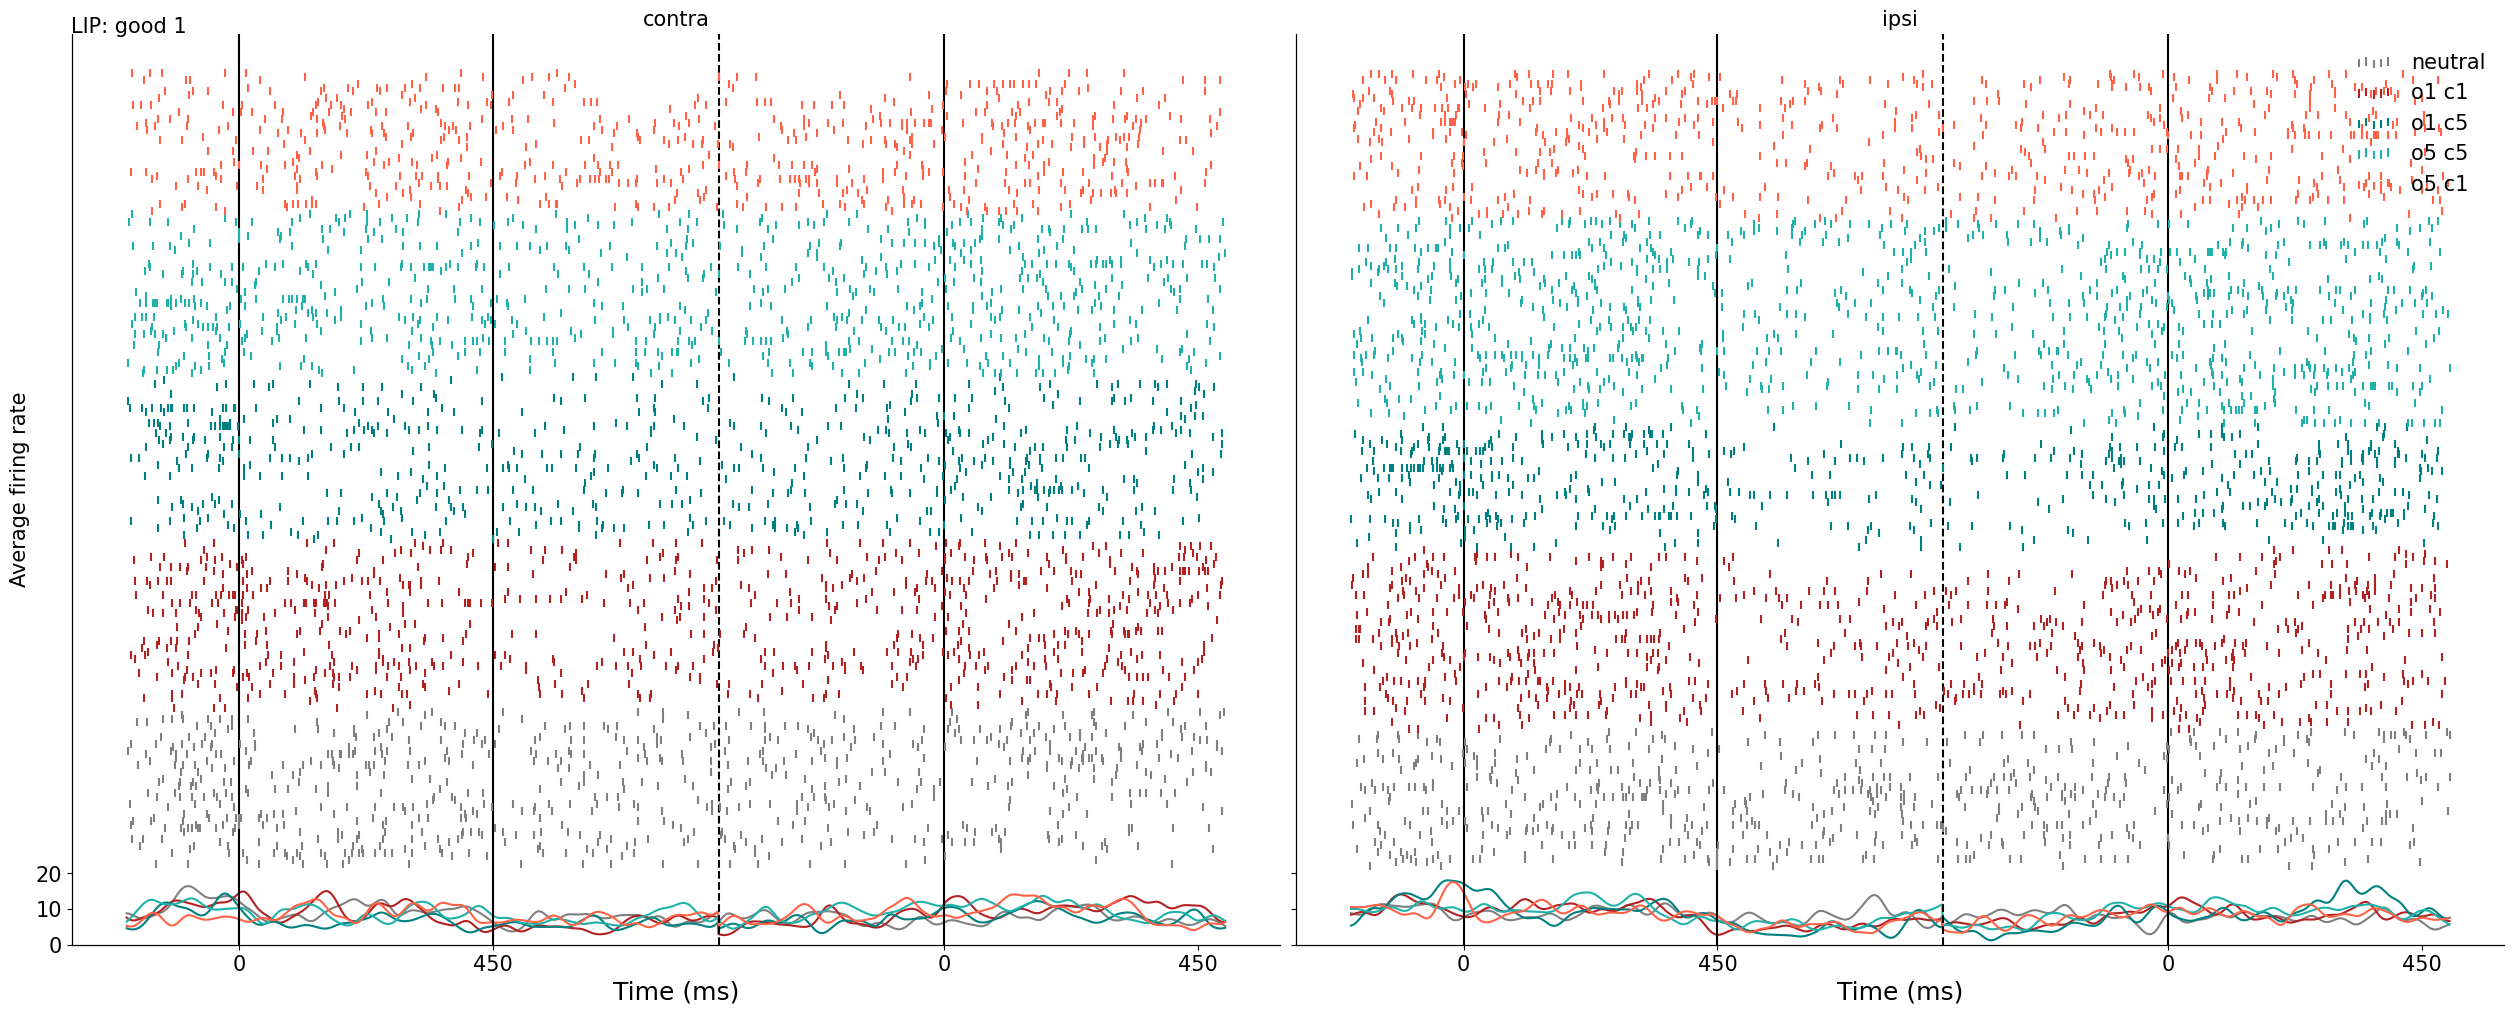

In [58]:
sp, conv = prepare_data_plotb1(neu,rf_stim_loc= ["contra", "ipsi"],q1=0.5,q2=99.5)
fig=neu.plot_sp_b1(sp, conv)

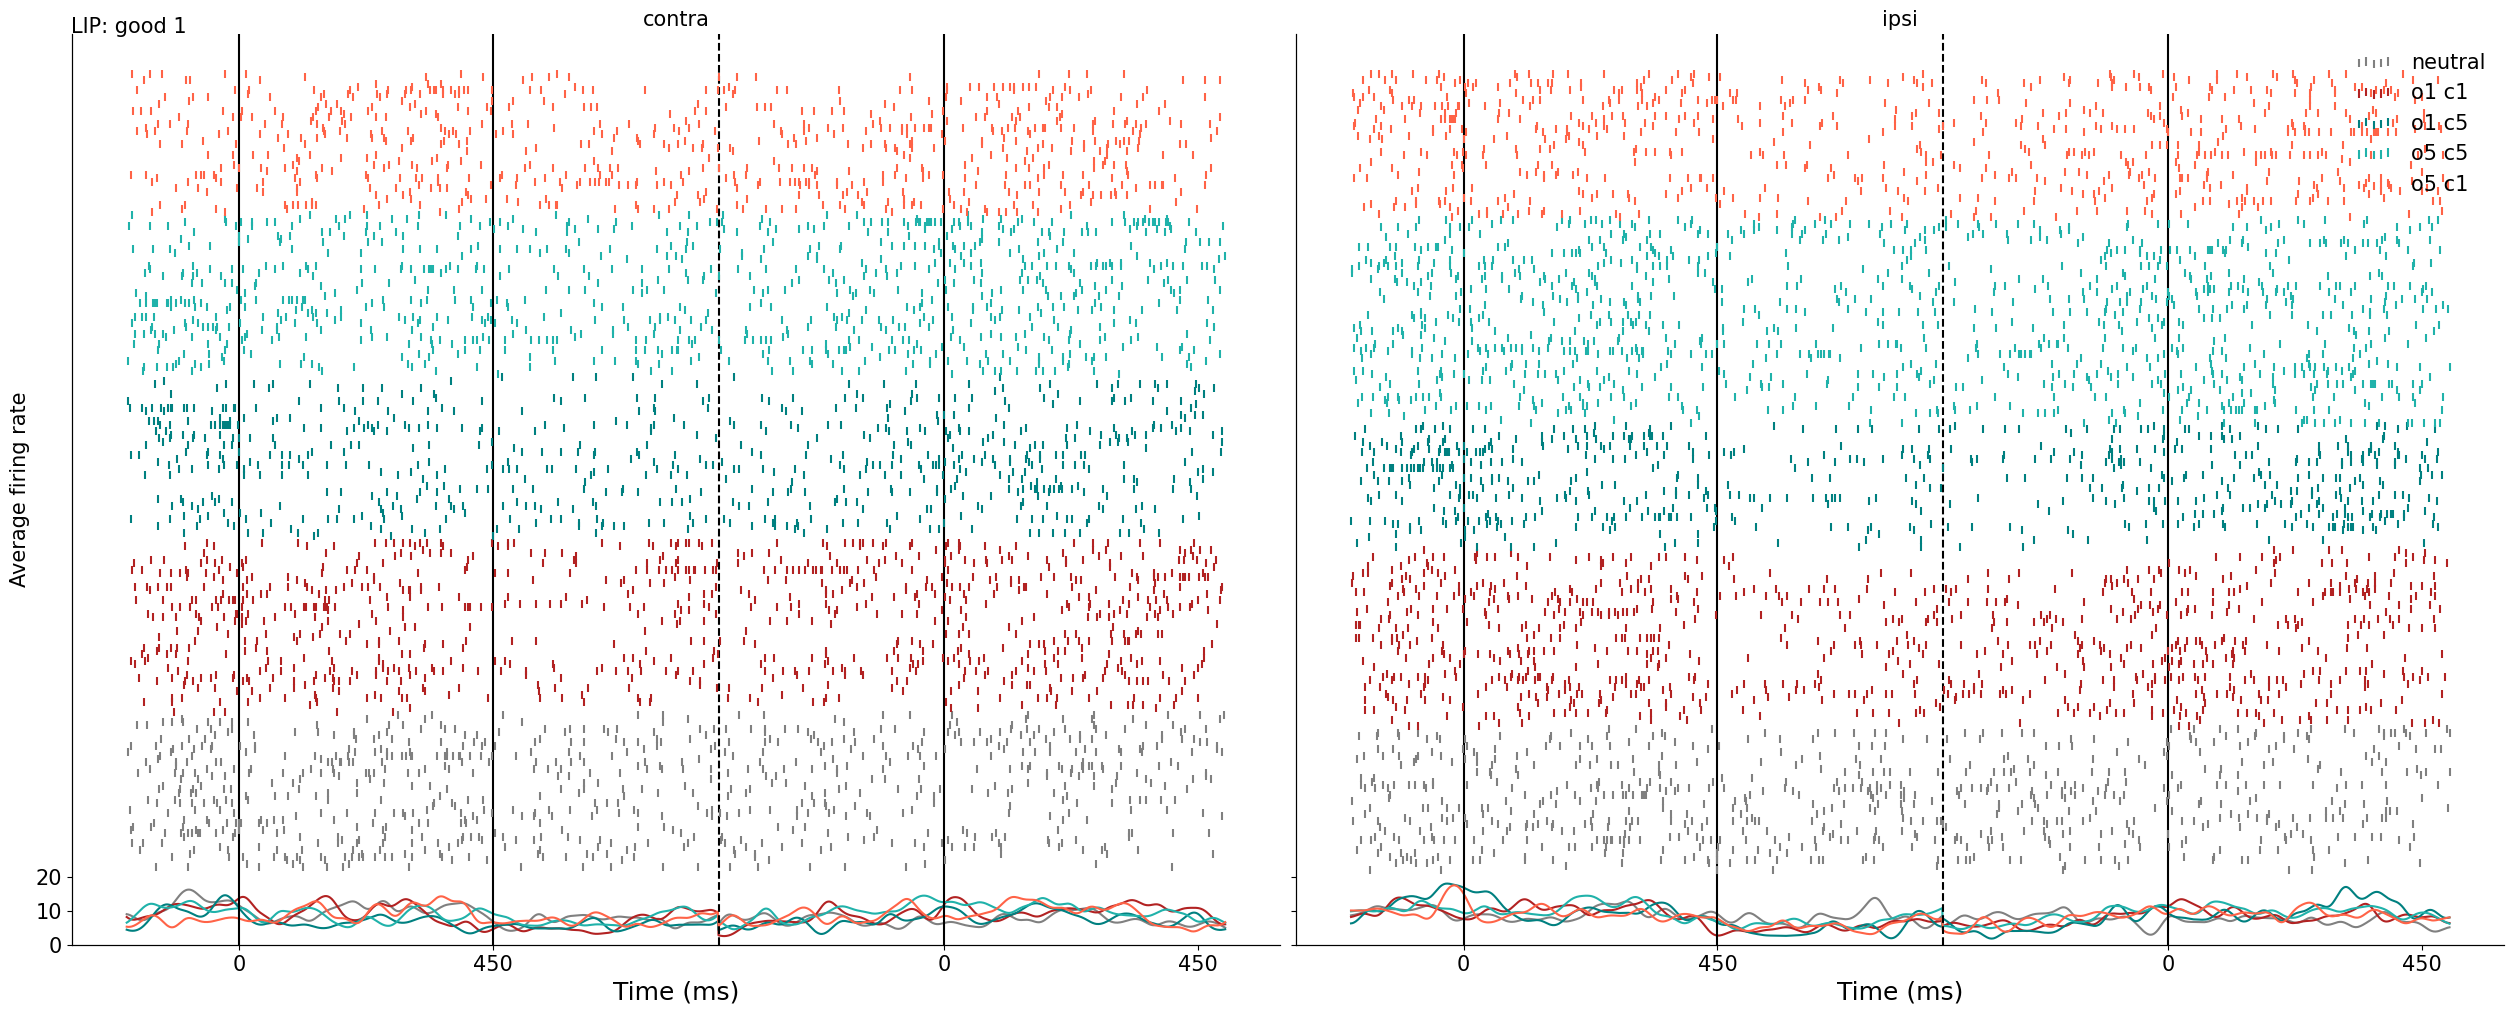

In [59]:
sp, conv = prepare_data_plotb1(neu,rf_stim_loc= ["contra", "ipsi"])
fig = neu.plot_sp_b1(sp, conv)

In [51]:
200*0.5/100

1.0

In [53]:
1*100/25

4.0